In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install seaborn


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour la reproductibilité et le style
np.random.seed(42)
sns.set_style("whitegrid")  # On utilise directement le style de seaborn

In [5]:
# Paramètres
intercept = 100  # Ordonnée à l'origine
slope = 2       # Pente
amplitude = 20  # Amplitude de la saisonnalité
period = 12    # Période (en mois)
sigma = 5      # Écart-type du bruit
years = 5      # Nombre d'années

# Calcul du nombre total de points
N = years * 12

# Création de l'index temporel
date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')
t = np.arange(N)

/tmp/ipython-input-2123323929.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')


In [6]:
# Tendance
trend = intercept + slope * t

# Saisonnalité
seasonality = amplitude * np.sin(2 * np.pi * t / period)

# Bruit gaussien
noise = np.random.normal(0, sigma, N)

# Combinaison des composantes
y = trend + seasonality + noise

# Création du DataFrame
df = pd.DataFrame({
    'date': date_rng,
    'valeur': y,
    'tendance': trend,
    'saisonnalite': seasonality,
    'bruit': noise
})
df.set_index('date', inplace=True)

print("Aperçu des données :")
print(df.head())

Aperçu des données :
                valeur  tendance  saisonnalite     bruit
date                                                    
2020-01-31  102.483571       100      0.000000  2.483571
2020-02-29  111.308678       102     10.000000 -0.691322
2020-03-31  124.558951       104     17.320508  3.238443
2020-04-30  133.615149       106     20.000000  7.615149
2020-05-31  124.149741       108     17.320508 -1.170767


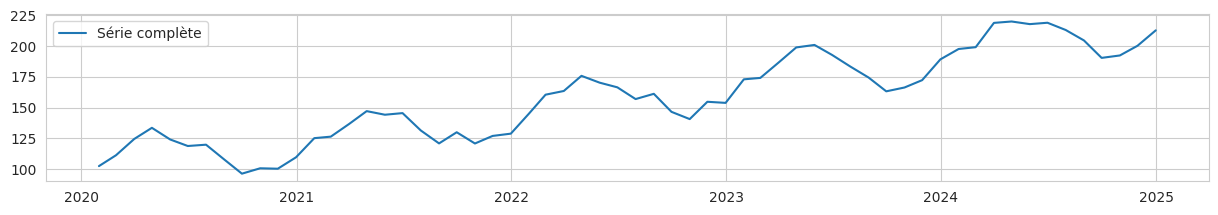

In [7]:
# Configuration de la figure
plt.figure(figsize=(15, 10))

# Création des sous-graphiques
plt.subplot(411)
plt.plot(df.index, df['valeur'], label='Série complète')
plt.legend()
plt.grid(True)

# Modèle NAIF

/tmp/ipython-input-3378733869.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')


Train: 2020-01-31 00:00:00 → 2023-06-30 00:00:00
Validation: 2023-07-31 00:00:00 → 2024-03-31 00:00:00
Test: 2024-04-30 00:00:00 → 2024-12-31 00:00:00

📊 Métriques du modèle NAÏF :
      dataset       MAE       RMSE      MAPE
0  validation  6.430811   8.033654  3.439523
1        test  9.427084  11.231983  4.537245

✅ Fichier 'metrics_naif.csv' sauvegardé dans le répertoire courant.


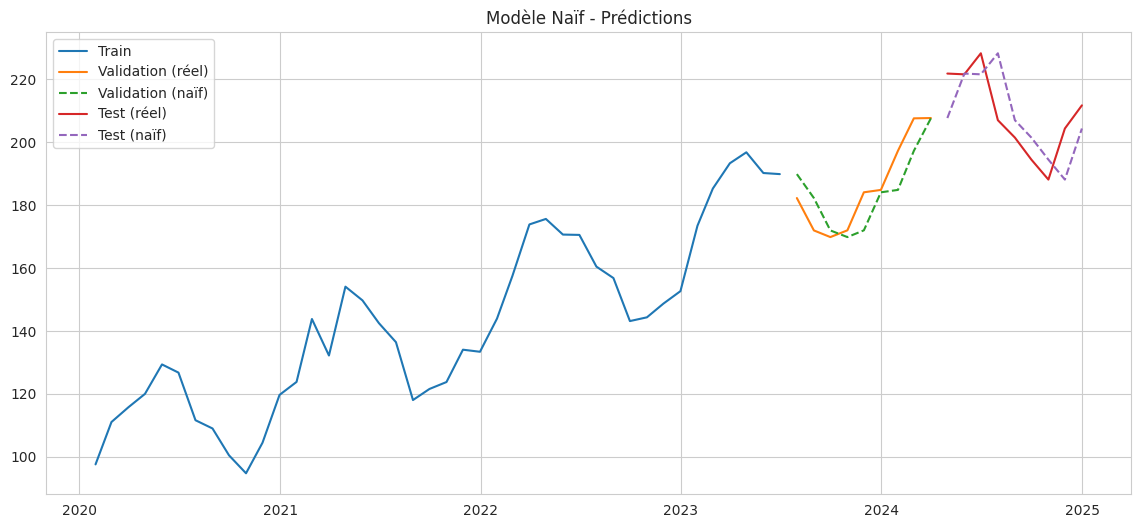

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==============================
# 1️⃣ Génération de la série synthétique
# ==============================
intercept = 100
slope = 2
amplitude = 20
period = 12
sigma = 5
years = 5

N = years * 12
date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')
t = np.arange(N)

trend = intercept + slope * t
seasonality = amplitude * np.sin(2 * np.pi * t / period)
noise = np.random.normal(0, sigma, N)
y = trend + seasonality + noise

df = pd.DataFrame({
    'date': date_rng,
    'valeur': y
})
df.set_index('date', inplace=True)

# ==============================
# 2️⃣ Split Train / Validation / Test
# ==============================
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print(f"Train: {train_df.index[0]} → {train_df.index[-1]}")
print(f"Validation: {val_df.index[0]} → {val_df.index[-1]}")
print(f"Test: {test_df.index[0]} → {test_df.index[-1]}")

# ==============================
# 3️⃣ Modèle NAÏF
# ==============================
# Prédiction naïve : la valeur suivante = dernière valeur observée
# On prédit sur la validation et le test
val_pred = val_df.shift(1)['valeur']
test_pred = test_df.shift(1)['valeur']

# Correction : la première prédiction est NaN, on la remplace par la première vraie valeur
val_pred.iloc[0] = train_df.iloc[-1]['valeur']
test_pred.iloc[0] = val_df.iloc[-1]['valeur']

# ==============================
# 4️⃣ Calcul des métriques
# ==============================
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

val_mae, val_rmse, val_mape = compute_metrics(val_df['valeur'], val_pred)
test_mae, test_rmse, test_mape = compute_metrics(test_df['valeur'], test_pred)

# ==============================
# 5️⃣ Tableau des métriques
# ==============================
metrics_df = pd.DataFrame({
    'dataset': ['validation', 'test'],
    'MAE': [val_mae, test_mae],
    'RMSE': [val_rmse, test_rmse],
    'MAPE': [val_mape, test_mape]
})

print("\n📊 Métriques du modèle NAÏF :")
print(metrics_df)

# ==============================
# 6️⃣ Sauvegarde des métriques (Drive ou local)
# ==============================
metrics_df.to_csv("metrics_naif.csv", index=False)
print("\n✅ Fichier 'metrics_naif.csv' sauvegardé dans le répertoire courant.")

# ==============================
# 7️⃣ Visualisation des prédictions
# ==============================
plt.figure(figsize=(14,6))
plt.plot(train_df.index, train_df['valeur'], label='Train')
plt.plot(val_df.index, val_df['valeur'], label='Validation (réel)')
plt.plot(val_df.index, val_pred, '--', label='Validation (naïf)')
plt.plot(test_df.index, test_df['valeur'], label='Test (réel)')
plt.plot(test_df.index, test_pred, '--', label='Test (naïf)')
plt.title("Modèle Naïf - Prédictions")
plt.legend()
plt.grid(True)
plt.show()


# Regression linéaire

/tmp/ipython-input-641254824.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')



📊 Métriques Régression Linéaire :
      dataset        MAE       RMSE      MAPE
0  validation  10.083940  11.914615  5.566019
1        test  11.540259  13.407084  5.610312
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Fichier 'metrics_regression_lineaire.csv' enregistré dans ton Google Drive.


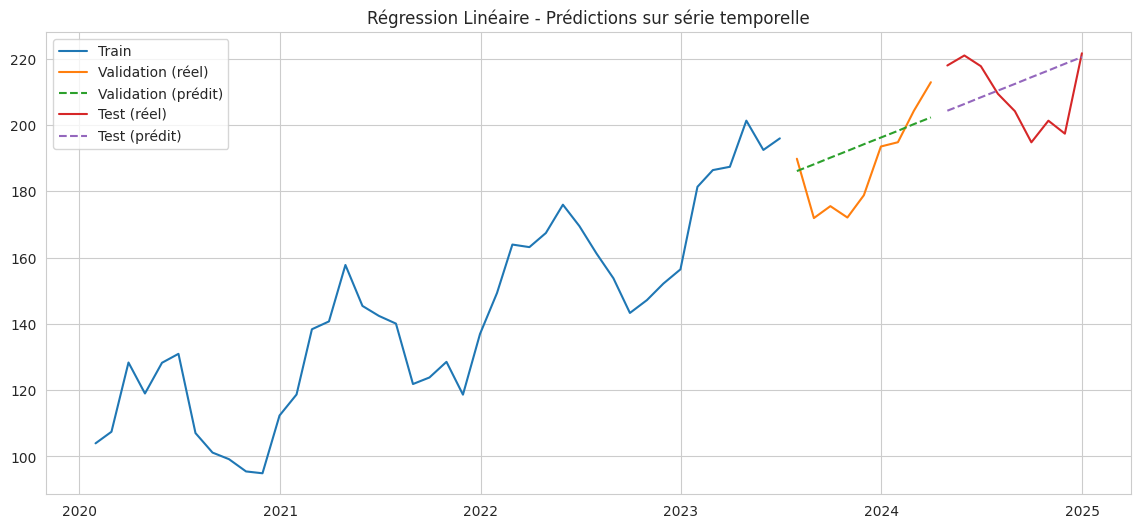

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==============================
# 1️⃣ Génération de la série temporelle synthétique
# ==============================
intercept = 100
slope = 2
amplitude = 20
period = 12
sigma = 5
years = 5

N = years * 12
date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')
t = np.arange(N).reshape(-1, 1)  # variable explicative (temps)

trend = intercept + slope * t.flatten()
seasonality = amplitude * np.sin(2 * np.pi * t.flatten() / period)
noise = np.random.normal(0, sigma, N)
y = trend + seasonality + noise

df = pd.DataFrame({
    'date': date_rng,
    't': t.flatten(),
    'valeur': y
})
df.set_index('date', inplace=True)

# ==============================
# 2️⃣ Split Train / Validation / Test
# ==============================
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

# ==============================
# 3️⃣ Régression Linéaire
# ==============================
model = LinearRegression()

X_train = train_df[['t']]
y_train = train_df['valeur']
X_val = val_df[['t']]
y_val = val_df['valeur']
X_test = test_df[['t']]
y_test = test_df['valeur']

model.fit(X_train, y_train)

# Prédictions
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# ==============================
# 4️⃣ Calcul des métriques
# ==============================
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

val_mae, val_rmse, val_mape = compute_metrics(y_val, val_pred)
test_mae, test_rmse, test_mape = compute_metrics(y_test, test_pred)

metrics_df = pd.DataFrame({
    'dataset': ['validation', 'test'],
    'MAE': [val_mae, test_mae],
    'RMSE': [val_rmse, test_rmse],
    'MAPE': [val_mape, test_mape]
})

print("\n📊 Métriques Régression Linéaire :")
print(metrics_df)

# ==============================
# 5️⃣ Sauvegarde dans Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')

metrics_df.to_csv('/content/drive/MyDrive/metrics_regression_lineaire.csv', index=False)
print("✅ Fichier 'metrics_regression_lineaire.csv' enregistré dans ton Google Drive.")

# ==============================
# 6️⃣ Visualisation des résultats
# ==============================
plt.figure(figsize=(14,6))
plt.plot(train_df.index, train_df['valeur'], label='Train')
plt.plot(val_df.index, val_df['valeur'], label='Validation (réel)')
plt.plot(val_df.index, val_pred, '--', label='Validation (prédit)')
plt.plot(test_df.index, test_df['valeur'], label='Test (réel)')
plt.plot(test_df.index, test_pred, '--', label='Test (prédit)')
plt.title("Régression Linéaire - Prédictions sur série temporelle")
plt.legend()
plt.grid(True)
plt.show()


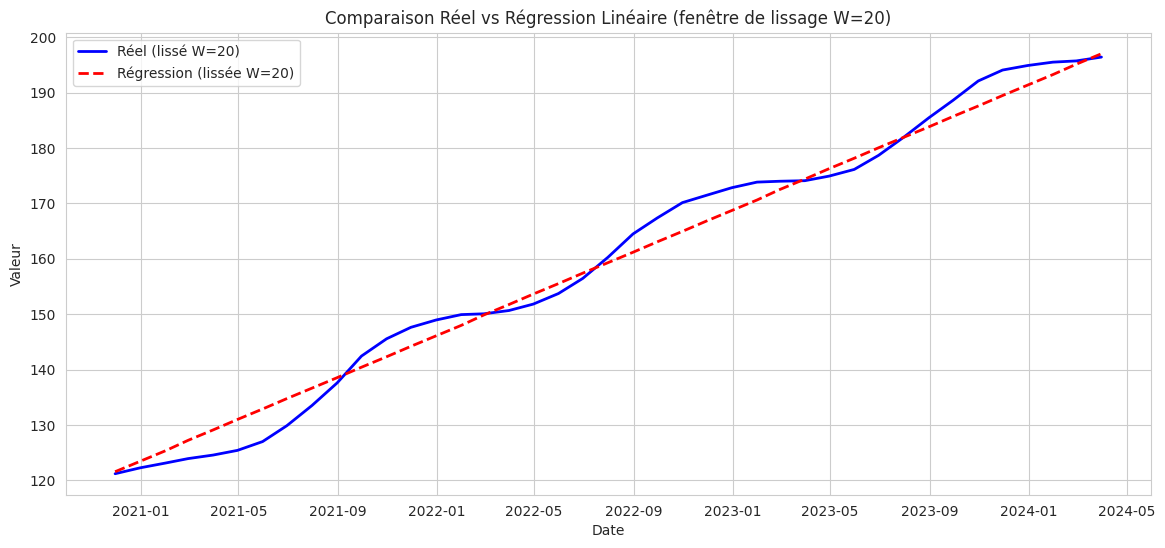

In [15]:
# 3️⃣ Lissage avec fenêtre W=20
# ==============================
W = 20
df['valeur_smooth'] = df['valeur'].rolling(window=W, center=True).mean()
df['pred_reg_smooth'] = df['pred_reg'].rolling(window=W, center=True).mean()

# ==============================
# 4️⃣ Visualisation : Réel vs Régression (W=20)
# ==============================
plt.figure(figsize=(14,6))
plt.plot(df.index, df['valeur_smooth'], label=f'Réel (lissé W={W})', color='blue', linewidth=2)
plt.plot(df.index, df['pred_reg_smooth'], label=f'Régression (lissée W={W})', color='red', linestyle='--', linewidth=2)
plt.title(f"Comparaison Réel vs Régression Linéaire (fenêtre de lissage W={W})")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)
plt.show()


# MLP

/tmp/ipython-input-415943825.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.1744 - val_loss: 0.2333
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1189 - val_loss: 0.1053
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0559 - val_loss: 0.0312
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0302 - val_loss: 0.0041
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0122 - val_loss: 0.0136
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0115 - val_loss: 0.0400
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0130 - val_loss: 0.0639
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0190 - val_loss: 0.0739
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0202 - val_loss: 0.0684
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0186 - val_loss: 0.0526
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0143 - val_loss: 0.0339
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0109 - 

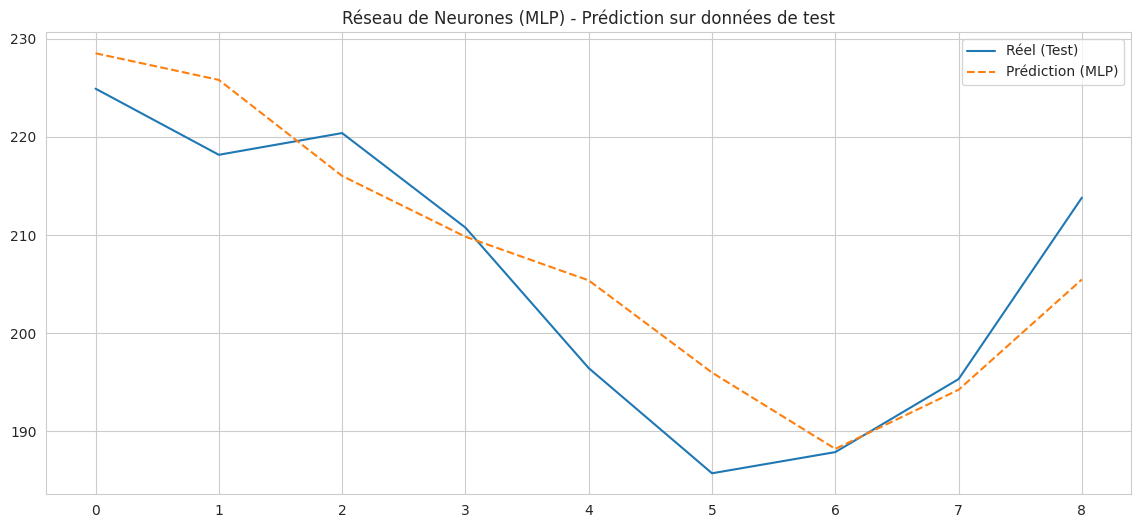

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# ==============================
# 1️⃣ Génération de la série temporelle synthétique
# ==============================
intercept = 100
slope = 2
amplitude = 20
period = 12
sigma = 5
years = 5

N = years * 12
date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')
t = np.arange(N)

trend = intercept + slope * t
seasonality = amplitude * np.sin(2 * np.pi * t / period)
noise = np.random.normal(0, sigma, N)
y = trend + seasonality + noise

df = pd.DataFrame({'date': date_rng, 'valeur': y})
df.set_index('date', inplace=True)

# ==============================
# 2️⃣ Split Train / Validation / Test
# ==============================
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

# ==============================
# 3️⃣ Préparation des données (fenêtres glissantes)
# ==============================
def create_dataset(series, window_size=12):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[['valeur']])

X_train, y_train = create_dataset(scaled_values[:train_size], window_size=12)
X_val, y_val = create_dataset(scaled_values[train_size - 12:train_size + val_size], window_size=12)
X_test, y_test = create_dataset(scaled_values[train_size + val_size - 12:], window_size=12)

# ==============================
# 4️⃣ Modèle de Réseau de Neurones (MLP)
# ==============================
model = Sequential([
    Dense(64, activation='relu', input_shape=(12,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Early stopping pour éviter le surapprentissage
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# ==============================
# 5️⃣ Évaluation du modèle
# ==============================
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# Inverser la normalisation
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
val_pred_inv = scaler.inverse_transform(val_pred)
test_pred_inv = scaler.inverse_transform(test_pred)

# Calcul des métriques
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

val_mae, val_rmse, val_mape = compute_metrics(y_val_inv, val_pred_inv)
test_mae, test_rmse, test_mape = compute_metrics(y_test_inv, test_pred_inv)

metrics_df = pd.DataFrame({
    'dataset': ['validation', 'test'],
    'MAE': [val_mae, test_mae],
    'RMSE': [val_rmse, test_rmse],
    'MAPE': [val_mape, test_mape]
})

print("\n📊 Métriques du Réseau de Neurones :")
print(metrics_df)

# ==============================
# 6️⃣ Visualisation
# ==============================
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Réel (Test)')
plt.plot(test_pred_inv, label='Prédiction (MLP)', linestyle='--')
plt.title("Réseau de Neurones (MLP) - Prédiction sur données de test")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-1558673182.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
📊 Résultats comparatifs :
                Modèle        MAE       RMSE        R2
0                 Naïf   8.283149  10.607540  0.912951
1  Régression Linéaire  13.089778  14.921489  0.831054
2                  MLP  12.363202  14.842126 -1.184022
3                  CNN   5.095112   5.497438  0.700370


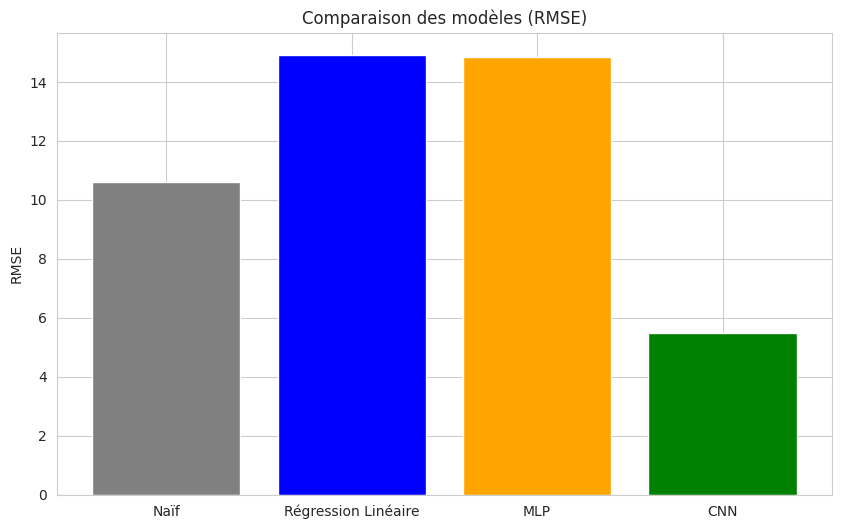

In [17]:
# =============================
# 📦 Imports
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import math

# =============================
# 1️⃣ Génération de la série temporelle synthétique
# =============================
intercept = 100
slope = 2
amplitude = 20
period = 12
sigma = 5
years = 5
N = years * 12

date_rng = pd.date_range(start='2020-01-01', periods=N, freq='M')
t = np.arange(N)
trend = intercept + slope * t
seasonality = amplitude * np.sin(2 * np.pi * t / period)
noise = np.random.normal(0, sigma, N)
y = trend + seasonality + noise

df = pd.DataFrame({'date': date_rng, 'valeur': y})
df.set_index('date', inplace=True)

# =============================
# 2️⃣ Split Train / Validation / Test
# =============================
train_size = int(0.7 * N)
val_size = int(0.15 * N)

train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

# =============================
# 3️⃣ Fonctions utilitaires
# =============================
def compute_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

# =============================
# 4️⃣ Modèle Naïf
# =============================
y_pred_naif = [np.nan] + list(df['valeur'][:-1])  # prédire la valeur précédente
df['pred_naif'] = y_pred_naif

metrics_naif = compute_metrics(df['valeur'].iloc[1:], df['pred_naif'].iloc[1:])

# =============================
# 5️⃣ Régression Linéaire
# =============================
X = np.arange(N).reshape(-1, 1)
y = df['valeur'].values
model_lr = LinearRegression()
model_lr.fit(X[:train_size], y[:train_size])
y_pred_lr = model_lr.predict(X)

metrics_lr = compute_metrics(y, y_pred_lr)

# =============================
# 6️⃣ MLP
# =============================
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Fenêtrage (W=12 mois)
W = 12
X_data, y_data = [], []
for i in range(W, len(y_scaled)):
    X_data.append(y_scaled[i-W:i])
    y_data.append(y_scaled[i])
X_data, y_data = np.array(X_data), np.array(y_data)

# Split aligné
split1 = int(0.7 * len(X_data))
split2 = int(0.85 * len(X_data))
X_train, X_val, X_test = X_data[:split1], X_data[split1:split2], X_data[split2:]
y_train, y_val, y_test = y_data[:split1], y_data[split1:split2], y_data[split2:]

model_mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
model_mlp.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())
y_pred_mlp = model_mlp.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_mlp_rescaled = scaler.inverse_transform(y_pred_mlp.reshape(-1, 1))

metrics_mlp = compute_metrics(
    scaler.inverse_transform(y_test.reshape(-1, 1)),
    y_pred_mlp_rescaled
)

# =============================
# 7️⃣ CNN
# =============================
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model_cnn = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(W, 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])
model_cnn.compile(optimizer=Adam(0.001), loss='mse')
model_cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=16,
              validation_data=(X_val_cnn, y_val), verbose=0)

y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn_rescaled = scaler.inverse_transform(y_pred_cnn)

metrics_cnn = compute_metrics(
    scaler.inverse_transform(y_test.reshape(-1, 1)),
    y_pred_cnn_rescaled
)

# =============================
# 8️⃣ Comparaison des modèles
# =============================
results = pd.DataFrame({
    'Modèle': ['Naïf', 'Régression Linéaire', 'MLP', 'CNN'],
    'MAE': [metrics_naif['MAE'], metrics_lr['MAE'], metrics_mlp['MAE'], metrics_cnn['MAE']],
    'RMSE': [metrics_naif['RMSE'], metrics_lr['RMSE'], metrics_mlp['RMSE'], metrics_cnn['RMSE']],
    'R2': [metrics_naif['R2'], metrics_lr['R2'], metrics_mlp['R2'], metrics_cnn['R2']]
})

print("📊 Résultats comparatifs :")
print(results)

# =============================
# 9️⃣ Sauvegarde des métriques
# =============================
results.to_csv('/content/drive/MyDrive/resultats_modeles.csv', index=False)

# =============================
# 🔟 Visualisation
# =============================
plt.figure(figsize=(10,6))
plt.bar(results['Modèle'], results['RMSE'], color=['gray','blue','orange','green'])
plt.title("Comparaison des modèles (RMSE)")
plt.ylabel("RMSE")
plt.show()


In [22]:
import tensorflow as tf

# Nous construisons un dataset pour prédire le pas suivant à partir d'une fenêtre de taille 20.

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Expand dimensions for the input (window[:-1]) to be (window_size, 1)
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (tf.expand_dims(window[:-1], axis=-1), window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Définir x_train en utilisant les données scaled_values ou y_scaled des cellules précédentes
# y_scaled est la série complète mise à l'échelle, train_size est la taille d'entraînement.
x_train = y_scaled[:train_size]

train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Pour la validation, on n'effectue pas de shuffle :
def windowed_dataset_val(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Expand dimensions for the input (window[:-1]) to be (window_size, 1)
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:-1], axis=-1), window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [26]:
# Fonction pour entraîner et évaluer un modèle
def train_and_evaluate(model, train_dataset, val_dataset, model_name, epochs=50):
    """
    Entraîne et évalue un modèle

    Args:
        model: Le modèle à entraîner
        train_dataset: Dataset d'entraînement
        val_dataset: Dataset de validation
        model_name: Nom du modèle pour l'affichage
        epochs: Nombre d'époques d'entraînement

    Returns:
        history: Historique d'entraînement
        mae: Mean Absolute Error sur le dataset de validation
    """
    # Compilation du modèle
    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae']
    )

    # Entraînement
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        verbose=0
    )

    # Évaluation
    loss, mae = model.evaluate(val_dataset)

    print(f"{model_name} - MAE: {mae:.4f}")

    return history, mae

# Définition des modèles

In [24]:
# Modèle MLP (Multi-Layer Perceptron)
def create_mlp_model(window_size):
    """
    Crée un modèle MLP simple

    Args:
        window_size: Taille de la fenêtre d'entrée

    Returns:
        model: Modèle MLP compilé
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[window_size, 1]), # Flatten the (window_size, 1) input for MLP
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [27]:
# Modèle RNN Simple
def create_simple_rnn_model(window_size):
    """
    Crée un modèle RNN simple

    Args:
        window_size: Taille de la fenêtre d'entrée

    Returns:
        model: Modèle RNN compilé
    """
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=[window_size, 1], return_sequences=True),
        tf.keras.layers.SimpleRNN(32),
        tf.keras.layers.Dense(1)
    ])

    return model


# Utilisation
window_size = 20

# Création du dataset de validation
# La validation doit commencer avant train_size pour que les fenêtres aient assez de données précédentes
val_start_index = train_size - window_size
val_end_index = train_size + val_size
x_val = y_scaled[val_start_index:val_end_index]
val_dataset = windowed_dataset_val(x_val, window_size, batch_size)

# Création des modèles
mlp_model = create_mlp_model(window_size)
rnn_model = create_simple_rnn_model(window_size)

# Entraînement et évaluation
print("Entraînement du modèle MLP...")
mlp_history, mlp_mae = train_and_evaluate(
    mlp_model,
    train_dataset,
    val_dataset,
    "MLP",
    epochs=50
)

print("\nEntraînement du modèle RNN Simple...")
rnn_history, rnn_mae = train_and_evaluate(
    rnn_model,
    train_dataset,
    val_dataset,
    "RNN Simple",
    epochs=50
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entraînement du modèle MLP...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0578 - mae: 0.0578
MLP - MAE: 0.0578

Entraînement du modèle RNN Simple...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0604 - mae: 0.0604
RNN Simple - MAE: 0.0604


In [28]:
# Modèle LSTM
def create_lstm_model(window_size):
    """
    Crée un modèle LSTM

    Args:
        window_size: Taille de la fenêtre d'entrée

    Returns:
        model: Modèle LSTM compilé
    """
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=[window_size, 1], return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])

    return model

In [29]:
# Modèle LSTM Bidirectionnel
def create_bidirectional_lstm_model(window_size):
    """
    Crée un modèle LSTM bidirectionnel

    Args:
        window_size: Taille de la fenêtre d'entrée

    Returns:
        model: Modèle LSTM bidirectionnel compilé
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=True),
            input_shape=[window_size, 1]
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(32)
        ),
        tf.keras.layers.Dense(1)
    ])

    return model


# Utilisation complète avec tous les modèles
window_size = 20

# Création des modèles
mlp_model = create_mlp_model(window_size)
rnn_model = create_simple_rnn_model(window_size)
lstm_model = create_lstm_model(window_size)
bidirectional_lstm_model = create_bidirectional_lstm_model(window_size)

# Entraînement et évaluation de tous les modèles
print("=" * 60)
print("Entraînement du modèle MLP...")
print("=" * 60)
mlp_history, mlp_mae = train_and_evaluate(
    mlp_model,
    train_dataset,
    val_dataset,
    "MLP",
    epochs=50
)

print("\n" + "=" * 60)
print("Entraînement du modèle RNN Simple...")
print("=" * 60)
rnn_history, rnn_mae = train_and_evaluate(
    rnn_model,
    train_dataset,
    val_dataset,
    "RNN Simple",
    epochs=50
)

print("\n" + "=" * 60)
print("Entraînement du modèle LSTM...")
print("=" * 60)
lstm_history, lstm_mae = train_and_evaluate(
    lstm_model,
    train_dataset,
    val_dataset,
    "LSTM",
    epochs=50
)

print("\n" + "=" * 60)
print("Entraînement du modèle LSTM Bidirectionnel...")
print("=" * 60)
bidirectional_lstm_history, bidirectional_lstm_mae = train_and_evaluate(
    bidirectional_lstm_model,
    train_dataset,
    val_dataset,
    "Bidirectional LSTM",
    epochs=50
)

# Comparaison des résultats
print("\n" + "=" * 60)
print("COMPARAISON DES PERFORMANCES")
print("=" * 60)
results = {
    "MLP": mlp_mae,
    "RNN Simple": rnn_mae,
    "LSTM": lstm_mae,
    "Bidirectional LSTM": bidirectional_lstm_mae
}

for model_name, mae in sorted(results.items(), key=lambda x: x[1]):
    print(f"{model_name:25s} - MAE: {mae:.4f}")

print("\nMeilleur modèle:", min(results, key=results.get))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entraînement du modèle MLP...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0362 - mae: 0.0362
MLP - MAE: 0.0362

Entraînement du modèle RNN Simple...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0919 - mae: 0.0919
RNN Simple - MAE: 0.0919

Entraînement du modèle LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1124 - mae: 0.1124
LSTM - MAE: 0.1124

Entraînement du modèle LSTM Bidirectionnel...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1110 - mae: 0.1110
Bidirectional LSTM - MAE: 0.1110

COMPARAISON DES PERFORMANCES
MLP                       - MAE: 0.0362
RNN Simple                - MAE: 0.0919
Bidirectional LSTM        - MAE: 0.1110
LSTM                      - MAE: 0.1124

Meilleur modèle: MLP


In [ ]:
# Modèle CNN 1D
def create_cnn_model(window_size):
    """
    Crée un modèle CNN 1D

    Args:
        window_size: Taille de la fenêtre d'entrée

    Returns:
        model: Modèle CNN 1D compilé
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=[window_size, 1]),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model


# Modèle CNN 1D plus profond (version alternative)
def create_deep_cnn_model(window_size):
    """
    Crée un modèle CNN 1D plus profond avec plus de couches

    Args:
        window_size: Taille de la fenêtre d'entrée

    Returns:
        model: Modèle CNN 1D profond compilé
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', input_shape=[window_size, 1]),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])

    return model


# Utilisation complète avec tous les modèles incluant CNN
window_size = 20

# Création des modèles
mlp_model = create_mlp_model(window_size)
rnn_model = create_simple_rnn_model(window_size)
lstm_model = create_lstm_model(window_size)
bidirectional_lstm_model = create_bidirectional_lstm_model(window_size)
cnn_model = create_cnn_model(window_size)

# Entraînement et évaluation de tous les modèles
print("=" * 60)
print("Entraînement du modèle MLP...")
print("=" * 60)
mlp_history, mlp_mae = train_and_evaluate(
    mlp_model,
    train_dataset,
    val_dataset,
    "MLP",
    epochs=50
)

print("\n" + "=" * 60)
print("Entraînement du modèle RNN Simple...")
print("=" * 60)
rnn_history, rnn_mae = train_and_evaluate(
    rnn_model,
    train_dataset,
    val_dataset,
    "RNN Simple",
    epochs=50
)

print("\n" + "=" * 60)
print("Entraînement du modèle LSTM...")
print("=" * 60)
lstm_history, lstm_mae = train_and_evaluate(
    lstm_model,
    train_dataset,
    val_dataset,
    "LSTM",
    epochs=50
)

print("\n" + "=" * 60)
print("Entraînement du modèle LSTM Bidirectionnel...")
print("=" * 60)
bidirectional_lstm_history, bidirectional_lstm_mae = train_and_evaluate(
    bidirectional_lstm_model,
    train_dataset,
    val_dataset,
    "Bidirectional LSTM",
    epochs=50
)

print("\n" + "=" * 60)
print("Entraînement du modèle CNN 1D...")
print("=" * 60)
cnn_history, cnn_mae = train_and_evaluate(
    cnn_model,
    train_dataset,
    val_dataset,
    "CNN 1D",
    epochs=50
)

# Comparaison des résultats
print("\n" + "=" * 60)
print("COMPARAISON DES PERFORMANCES")
print("=" * 60)
results = {
    "MLP": mlp_mae,
    "RNN Simple": rnn_mae,
    "LSTM": lstm_mae,
    "Bidirectional LSTM": bidirectional_lstm_mae,
    "CNN 1D": cnn_mae
}

for model_name, mae in sorted(results.items(), key=lambda x: x[1]):
    print(f"{model_name:25s} - MAE: {mae:.4f}")

print("\nMeilleur modèle:", min(results, key=results.get))

# Affichage des architectures
print("\n" + "=" * 60)
print("ARCHITECTURES DES MODÈLES")
print("=" * 60)

print("\n--- CNN 1D ---")
cnn_model.summary()

Entraînement du modèle MLP...
      1/Unknown 0s 17ms/step - loss: 0.0299 - mae: 0.0299